In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

import tqdm

import importlib
sys.path.insert(0, '../')
import enhancer_gene_utils
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '../enhancer_gene_utils.py'>

In [2]:
today = datetime.date.today()
print(today)

2021-01-08


# Get grand summary 
### - 80% cells for 5-time downsampling

In [3]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_res = '/cndd2/fangming/projects/scf_enhancers/results/{}_metacell_corr_res_{{}}'.format(today)
print(output_res)

/cndd2/fangming/projects/scf_enhancers/results/2021-01-08_metacell_corr_res_{}


In [4]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = (pd.read_csv(input_enh_gene_table, sep='\t')
                             [['gene', 'ens', 'dist']]
                             .rename(columns={'ens': 'enh'})
                        )

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 3)
6.211456298828125


,gene,enh,dist
0,ENSMUSG00000000001,147520,995118
1,ENSMUSG00000000001,147522,985740
2,ENSMUSG00000000001,147523,983725
3,ENSMUSG00000000001,147527,970444
4,ENSMUSG00000000001,147528,969372


In [5]:
# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201130_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)

print(res_clsts.shape)
res_clsts.head()

0it [00:00, ?it/s]

(25, 3)


25it [00:06,  4.11it/s]

(1025, 4)


,k,i,r,num_clst
0,100,0,1.000000,16
1,100,0,1.258925,20
2,100,0,1.584893,24
3,100,0,1.995262,29
4,100,0,2.511886,34


In [6]:
# a little hack
res_clsts['rM'] = (res_clsts['r']*1e6).astype(int)

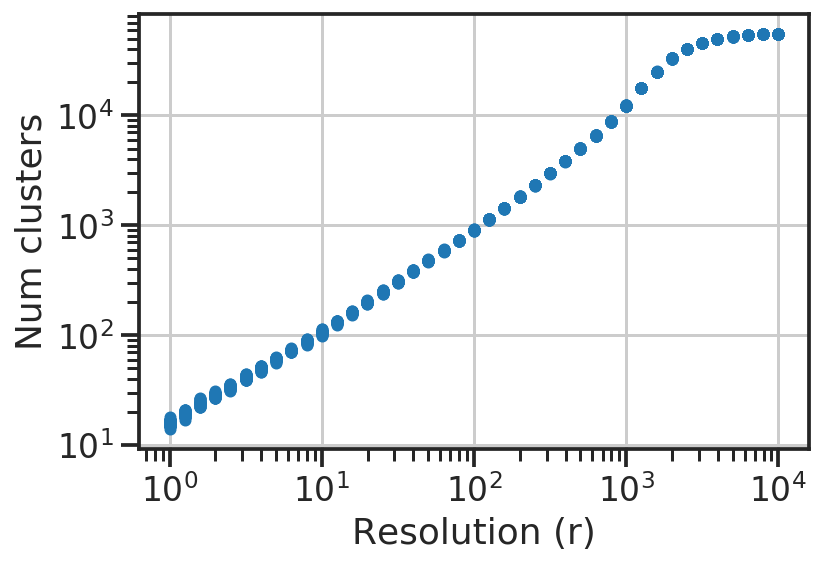

In [7]:
fig, ax = plt.subplots()
ax.plot(res_clsts['r'].values, res_clsts['num_clst'].values, 'o', markersize=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Resolution (r)')
ax.set_ylabel('Num clusters')
plt.show()

In [8]:
bins = np.linspace(-1,1,201)
fdr_threshold = 0.2
distance_threshold = 1e5
label = 'pairs (<100kb)'

col_orders = [
            'num_linked_pairs',
            'num_linked_genes',
            'num_linked_enhs',
            'id_linked_pairs',
    
            'num_correlated_pairs',
            'num_correlated_genes',
            'num_correlated_enhs',
            'id_correlated_pairs',
    
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
            'id_total_pairs',
    
            'r_th_linked', 
            'r_th_correlated_left',
            'r_th_correlated_right',
    ]

In [9]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201130"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201130"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
print(iterator_both.shape)
iterator_both.head()

(750, 4)
(750, 4)
(750, 5)


,r,i,k,fname_mc,fname_atac
0,1.000000,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
1,1.258925,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
2,1.584893,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
3,1.995262,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
4,10.000000,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...


In [10]:
# calc corr
iterator_both = iterator_both.sort_values(['r', 'i'])
# ## test
# res_corr = enhancer_gene_utils.get_corr_stats(iterator_both.iloc[[0, 1]], 
#                                               enhancer_gene_to_eval, col_orders) 
# ## end of test

res_corr = enhancer_gene_utils.get_corr_stats(iterator_both, 
                                              enhancer_gene_to_eval, col_orders) 
iterator_both = iterator_both.join(res_corr)
# a little hack to avoid merge on float number
iterator_both['rM'] = (iterator_both['r']*1e6).astype(int)

# merge with res_clsts
iterator_both = pd.merge(iterator_both, res_clsts.drop('r', axis=1), on=['rM', 'i', 'k'], how='inner')

750it [29:26,  2.36s/it]

(750, 39)


In [11]:
# save this bit
output = output_res.format('grand_res_summary_table.tsv.gz')
print(output)
iterator_both.to_csv(output, sep='\t', header=True, index=False)

/cndd2/fangming/projects/scf_enhancers/results/2021-01-08_metacell_corr_res_grand_res_summary_table.tsv.gz


In [12]:
iterator_both = pd.read_csv(output, sep='\t')
print(iterator_both.shape)
iterator_both.head()

(750, 46)


,r,i,k,fname_mc,fname_atac,num_linked_pairs_mc,num_linked_genes_mc,num_linked_enhs_mc,id_linked_pairs_mc,num_correlated_pairs_mc,...,num_linked_genes_both,num_linked_enhs_both,num_correlated_pairs_both,num_correlated_genes_both,num_correlated_enhs_both,num_total_pairs_both,num_total_genes_both,num_total_enhs_both,rM,num_clst
0,1.0,0,100,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2798,1104,2640,[ 475 698 1192 ... 2585888 2586075 2...,64766,...,244,354,14563,5269,12332,219808,16157,95613,1000000,16
1,1.0,0,10,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,864,479,844,[ 1540 1542 1544 4692 8636 86...,60100,...,46,57,16156,5705,13403,219808,16157,95613,1000000,16
2,1.0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,3782,1417,3551,[ 475 481 487 ... 2585888 2586076 2...,52814,...,241,341,20715,6424,16902,219808,16157,95613,1000000,16
3,1.0,0,50,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2743,1140,2597,[ 475 487 698 ... 2586075 2586076 2...,52454,...,154,202,18339,6027,15046,219808,16157,95613,1000000,16
4,1.0,0,5,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1180,604,1139,[ 1540 1541 1542 ... 2571616 2585868 2...,59630,...,52,60,20306,6407,16456,219808,16157,95613,1000000,16


In [13]:
iterator_both.columns

Index(['r', 'i', 'k', 'fname_mc', 'fname_atac', 'num_linked_pairs_mc',
       'num_linked_genes_mc', 'num_linked_enhs_mc', 'id_linked_pairs_mc',
       'num_correlated_pairs_mc', 'num_correlated_genes_mc',
       'num_correlated_enhs_mc', 'id_correlated_pairs_mc',
       'num_total_pairs_mc', 'num_total_genes_mc', 'num_total_enhs_mc',
       'id_total_pairs_mc', 'r_th_linked_mc', 'r_th_correlated_left_mc',
       'r_th_correlated_right_mc', 'num_linked_pairs_atac',
       'num_linked_genes_atac', 'num_linked_enhs_atac', 'id_linked_pairs_atac',
       'num_correlated_pairs_atac', 'num_correlated_genes_atac',
       'num_correlated_enhs_atac', 'id_correlated_pairs_atac',
       'num_total_pairs_atac', 'num_total_genes_atac', 'num_total_enhs_atac',
       'id_total_pairs_atac', 'r_th_linked_atac', 'r_th_correlated_left_atac',
       'r_th_correlated_right_atac', 'num_linked_pairs_both',
       'num_linked_genes_both', 'num_linked_enhs_both',
       'num_correlated_pairs_both', 'num_correl